In [138]:
%matplotlib inline
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.utils.data as torch_data
import sklearn
from sklearn.metrics import accuracy_score

In [139]:
from poslayers.poslayers import *

In [140]:
# fetch the dataset.
digits, targets = load_digits(return_X_y=True)
digits = digits.astype(np.float32) / 255

digits_train, digits_test, targets_train, targets_test = train_test_split(digits, targets, random_state=0)

train_size = digits_train.shape[0]

input_size = 8*8
classes_n = 10

In [141]:
class MNISTData(torch_data.Dataset):
    def __init__(self, X, y):
        super(MNISTData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return (self.X[idx],self.y[idx])

In [142]:
def get_accuracy(net, val_dset):
    test_loader = torch_data.DataLoader(val_dset,batch_size = len(val_dset)) 
    net.eval()
    for X,y in test_loader:
        X = X.to(device)
        nn_outputs = net(X).detach().numpy().argmax(axis = 1)
    return accuracy_score(nn_outputs,y.detach().numpy())

In [143]:
train_dset = MNISTData(digits_train, targets_train) 
val_dset = MNISTData(digits_test, targets_test) 

## Non-convex FCN

In [144]:
class FCN(nn.Module):

    def __init__(self):
        super(FCN, self).__init__()
        self.fc0 = Dense(64, 40)
        self.fc1 = Dense(40, 20)
        self.fc2 = Dense(20, 10)
        self.fc3 = Dense(10, 10)

    def forward(self, input_):
        h1 = F.relu(self.fc0(input_))
        h2 = F.relu(self.fc1(h1))
        h3 = self.fc2(h2)
        return h3
    
    def get_sparsities(self):
        return {
                'Dense1': self.fc0.get_sparsity(),
                'Dense2': self.fc1.get_sparsity(),
                'Dense3': self.fc2.get_sparsity(),
        }
    
    def l1reg(self, device):
        return self.fc0.l1reg(device) + self.fc1.l1reg(device) + self.fc2.l1reg(device)

In [145]:
device = 'cpu'

net = FCN()  
criterion = F.cross_entropy
optimizer = torch.optim.Adam(net.parameters())
scheduler = None

train_loader = torch_data.DataLoader(train_dset, batch_size=30, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size=100, shuffle=False) 

In [146]:
net

FCN(
  (fc0): Dense(in_features=64, out_features=40, bias=True)
  (fc1): Dense(in_features=40, out_features=20, bias=True)
  (fc2): Dense(in_features=20, out_features=10, bias=True)
  (fc3): Dense(in_features=10, out_features=10, bias=True)
)

In [147]:
net

FCN(
  (fc0): Dense(in_features=64, out_features=40, bias=True)
  (fc1): Dense(in_features=40, out_features=20, bias=True)
  (fc2): Dense(in_features=20, out_features=10, bias=True)
  (fc3): Dense(in_features=10, out_features=10, bias=True)
)

In [148]:
def train_fcn(epochs, net, criterion, optimizer, train_loader,
               val_loader, ds_train, ds_val,
               scheduler=None, verbose=True, save_dir=None, l1alpha=0, model_file='model', positivate=False):
    net.to(device)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    best_val_loss = np.inf

    for epoch in range(1, epochs+1):
        net.train()
        loss = []
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            nn_outputs = net(X)

            loss1 = criterion(nn_outputs, y) + l1alpha * net.l1reg(device)
            loss1 = loss1.to(device)
            optimizer.zero_grad()
            loss1.backward()
            loss.append(loss1.item())
            optimizer.step()
            if positivate:
                net.positivate()
        net.eval()
        val_loss = []
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)
            nn_outputs = net(X)
            val_loss1 = criterion(nn_outputs,y)
            val_loss.append(val_loss1.item())
         
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,1)

        train_losses.append(np.mean(loss))
        val_losses.append(np.mean(val_loss))
        train_accs.append(get_accuracy(net, ds_train))
        val_accs.append(get_accuracy(net, ds_val))


        if np.mean(val_loss) < best_val_loss:
            best_val_loss = np.mean(val_loss)
            torch.save(net.state_dict(), model_file)

        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, np.mean(loss), np.mean(val_loss)))
          
    np.save(f'val_loss_{model_file}', val_losses)
    np.save(f'train_loss_{model_file}', train_losses)
    np.save(f'val_acc_{model_file}', val_accs)
    np.save(f'train_acc_{model_file}', train_accs)

In [149]:
train_fcn(400, net, criterion, optimizer, train_loader, val_loader,
          train_dset, val_dset, model_file='fcn', scheduler=scheduler)

Epoch 20/400 || Loss:  Train 0.5686 | Validation 0.6189
Epoch 40/400 || Loss:  Train 0.3175 | Validation 0.3668
Epoch 60/400 || Loss:  Train 0.2311 | Validation 0.2825
Epoch 80/400 || Loss:  Train 0.1865 | Validation 0.2551
Epoch 100/400 || Loss:  Train 0.1550 | Validation 0.2329
Epoch 120/400 || Loss:  Train 0.1345 | Validation 0.2321
Epoch 140/400 || Loss:  Train 0.1161 | Validation 0.2258
Epoch 160/400 || Loss:  Train 0.1018 | Validation 0.2258
Epoch 180/400 || Loss:  Train 0.0858 | Validation 0.2164
Epoch 200/400 || Loss:  Train 0.0751 | Validation 0.2197
Epoch 220/400 || Loss:  Train 0.0654 | Validation 0.2181
Epoch 240/400 || Loss:  Train 0.0589 | Validation 0.2186
Epoch 260/400 || Loss:  Train 0.0483 | Validation 0.2185
Epoch 280/400 || Loss:  Train 0.0412 | Validation 0.2225
Epoch 300/400 || Loss:  Train 0.0358 | Validation 0.2188
Epoch 320/400 || Loss:  Train 0.0289 | Validation 0.2250
Epoch 340/400 || Loss:  Train 0.0233 | Validation 0.2313
Epoch 360/400 || Loss:  Train 0.019

In [150]:
net.load_state_dict(torch.load('fcn'))

<All keys matched successfully>

In [151]:
get_accuracy(net, val_dset)

0.9466666666666667

In [152]:
fcn_val_losses = np.load('val_loss_fcn.npy')
fcn_val_accs = np.load('val_acc_fcn.npy')

In [153]:
def plot_losses_accs(train_losses, val_losses, train_accs, val_accs):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
    axs[0].grid()
    axs[0].plot(train_losses, label="train loss")
    axs[0].plot(val_losses, label="val loss")
    axs[0].set_xlabel("Epoch", fontsize=14)
    axs[0].set_ylabel("Loss", fontsize=14)
    axs[0].legend(fontsize=14)
    
    axs[1].grid()
    axs[1].plot(train_accs, label="train acc")
    axs[1].plot(val_accs, label="val acc")
    axs[1].set_xlabel("Epoch", fontsize=14)
    axs[1].set_ylabel("Accuracy", fontsize=14)
    axs[1].legend(fontsize=14)
    plt.show()

In [154]:
net.get_sparsities()

{'Dense1': 0.0, 'Dense2': 0.0, 'Dense3': 0.0}

## POSDENSE = CNN WITHOUT ADDITIONAL LAYERS

In [155]:
class ICNN(nn.Module):

    def __init__(self):
        super(ICNN, self).__init__()
        self.fcpos0 = PosDense(64, 40)
        self.fcpos1 = PosDense(40, 20)
        self.fcpos2 = PosDense(20, 10)
        self.fc = Dense(10, 10)

    def forward(self, input_):
        h1 = F.relu(self.fcpos0(input_))
        h2 = F.relu(self.fcpos1(h1))
        h3 = F.relu(self.fcpos2(h2))
        h4 = self.fc(h3)
        return h4
    
    def positivate(self):
        self.fcpos0.positivate()
        self.fcpos1.positivate()
        self.fcpos2.positivate()
    
    def get_sparsities(self):
        get_sparsity = lambda layer : (layer.weight.data == 0).sum().item() / (layer.weight.data.shape[0] * layer.weight.data.shape[1])
        return {
                'PosDense1': get_sparsity(self.fcpos0),
                'PosDense2': get_sparsity(self.fcpos1),
                'PosDense3': get_sparsity(self.fcpos2),
                'Dense' : get_sparsity(self.fc)
        }
    
    def l1reg(self, device):
        return self.fcpos0.l1reg(device) + self.fcpos1.l1reg(device) + self.fcpos2.l1reg(device) + self.fc.l1reg(device)

In [156]:
device = 'cpu'

net = ICNN()  
criterion = F.cross_entropy
optimizer = torch.optim.Adam(net.parameters())
scheduler = None

train_loader = torch_data.DataLoader(train_dset, batch_size=30, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size=100, shuffle=False) 

In [157]:
net

ICNN(
  (fcpos0): PosDense(in_features=64, out_features=40, bias=True)
  (fcpos1): PosDense(in_features=40, out_features=20, bias=True)
  (fcpos2): PosDense(in_features=20, out_features=10, bias=True)
  (fc): Dense(in_features=10, out_features=10, bias=True)
)

In [158]:
def train_icnn(epochs, net, criterion, optimizer, train_loader, val_loader,scheduler=None, verbose=True, save_dir=None, l1alpha=0):
    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        loss = []
        for X, y in train_loader:
            nn_outputs = net(X)
            loss1 = criterion(nn_outputs, y) + l1alpha * net.l1reg()
            optimizer.zero_grad()
            loss1.backward()
            loss.append(loss1.item())
            optimizer.step()
            net.positivate()
        net.eval()
        val_loss = []
        for X, y in val_loader:
            X = X.to(device)
            nn_outputs = net(X)
            val_loss1 = criterion(nn_outputs,y)
            val_loss.append(val_loss1.item())
         
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,1)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, np.mean(loss), np.mean(val_loss)))

In [159]:
train_fcn(400, net, criterion, optimizer, train_loader, val_loader,
          train_dset, val_dset, model_file='icnn', scheduler=scheduler, positivate=True)

Epoch 20/400 || Loss:  Train 1.6679 | Validation 1.6785
Epoch 40/400 || Loss:  Train 1.4279 | Validation 1.4580
Epoch 60/400 || Loss:  Train 1.2809 | Validation 1.3266
Epoch 80/400 || Loss:  Train 1.0759 | Validation 1.1438
Epoch 100/400 || Loss:  Train 0.8191 | Validation 0.9062
Epoch 120/400 || Loss:  Train 0.6649 | Validation 0.7515
Epoch 140/400 || Loss:  Train 0.5635 | Validation 0.6407
Epoch 160/400 || Loss:  Train 0.4676 | Validation 0.5561
Epoch 180/400 || Loss:  Train 0.3845 | Validation 0.4831
Epoch 200/400 || Loss:  Train 0.3207 | Validation 0.4237
Epoch 220/400 || Loss:  Train 0.2647 | Validation 0.3706
Epoch 240/400 || Loss:  Train 0.2295 | Validation 0.3547
Epoch 260/400 || Loss:  Train 0.1863 | Validation 0.3200
Epoch 280/400 || Loss:  Train 0.1606 | Validation 0.3050
Epoch 300/400 || Loss:  Train 0.1324 | Validation 0.2814
Epoch 320/400 || Loss:  Train 0.1098 | Validation 0.2632
Epoch 340/400 || Loss:  Train 0.0892 | Validation 0.2624
Epoch 360/400 || Loss:  Train 0.074

In [160]:
net.load_state_dict(torch.load('icnn'))

<All keys matched successfully>

In [161]:
icnn_val_losses = np.load('val_loss_icnn.npy')
icnn_val_accs = np.load('val_acc_icnn.npy')

In [162]:
get_accuracy(net, val_dset)

0.9333333333333333

In [163]:
def get_size(x):
    return x.shape[0] * x.shape[1]

In [164]:
sparsities = net.get_sparsities()

In [165]:
sparsities

{'PosDense1': 0.30234375,
 'PosDense2': 0.25875,
 'PosDense3': 0.065,
 'Dense': 0.0}

In [166]:
s0 = sparsities['PosDense1'] * get_size(net.fcpos0.weight.data)
s1 = sparsities['PosDense2'] * get_size(net.fcpos1.weight.data)
s2 = sparsities['PosDense3'] * get_size(net.fcpos2.weight.data)
s3 = sparsities['Dense'] * get_size(net.fc.weight.data)

In [167]:
(s0 + s1 + s2 + s3) /(get_size(net.fcpos0.weight.data) + get_size(net.fcpos1.weight.data) + get_size(net.fcpos2.weight.data) + get_size(net.fc.weight.data))

0.2715846994535519

## L1 + ICNN

In [168]:
device = 'cpu'

net = ICNN()  
criterion = F.cross_entropy 
optimizer = torch.optim.Adam(net.parameters())
scheduler = None

train_loader = torch_data.DataLoader(train_dset, batch_size=30, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size=100, shuffle=False) 

In [169]:
train_fcn(400, net, criterion, optimizer, train_loader, val_loader,
          train_dset, val_dset, model_file='icnnl1', scheduler=scheduler, positivate=True, l1alpha=1e-4)

Epoch 20/400 || Loss:  Train 1.7125 | Validation 1.7371
Epoch 40/400 || Loss:  Train 1.5256 | Validation 1.5413
Epoch 60/400 || Loss:  Train 1.4580 | Validation 1.4684
Epoch 80/400 || Loss:  Train 1.3554 | Validation 1.3656
Epoch 100/400 || Loss:  Train 1.1415 | Validation 1.1842
Epoch 120/400 || Loss:  Train 0.9986 | Validation 1.0395
Epoch 140/400 || Loss:  Train 0.9228 | Validation 0.9295
Epoch 160/400 || Loss:  Train 0.8525 | Validation 0.8674
Epoch 180/400 || Loss:  Train 0.7873 | Validation 0.7868
Epoch 200/400 || Loss:  Train 0.7414 | Validation 0.7511
Epoch 220/400 || Loss:  Train 0.6914 | Validation 0.6951
Epoch 240/400 || Loss:  Train 0.6393 | Validation 0.6363
Epoch 260/400 || Loss:  Train 0.5691 | Validation 0.5629
Epoch 280/400 || Loss:  Train 0.5047 | Validation 0.4697
Epoch 300/400 || Loss:  Train 0.4631 | Validation 0.4316
Epoch 320/400 || Loss:  Train 0.4348 | Validation 0.4011
Epoch 340/400 || Loss:  Train 0.4203 | Validation 0.3813
Epoch 360/400 || Loss:  Train 0.393

In [170]:
net.load_state_dict(torch.load('icnnl1'))

<All keys matched successfully>

In [171]:
icnnl1_val_losses = np.load('val_loss_icnnl1.npy')
icnnl1_val_accs = np.load('val_acc_icnnl1.npy')

In [172]:
get_accuracy(net, val_dset)

0.8933333333333333

In [173]:
net.get_sparsities()

{'PosDense1': 0.61328125,
 'PosDense2': 0.6575,
 'PosDense3': 0.355,
 'Dense': 0.0}

In [174]:
sparsities = net.get_sparsities()

In [175]:
s0 = sparsities['PosDense1'] * get_size(net.fcpos0.weight.data)
s1 = sparsities['PosDense2'] * get_size(net.fcpos1.weight.data)
s2 = sparsities['PosDense3'] * get_size(net.fcpos2.weight.data)
s3 = sparsities['Dense'] * get_size(net.fc.weight.data)

In [176]:
(s0 + s1 + s2 + s3) /(get_size(net.fcpos0.weight.data) + get_size(net.fcpos1.weight.data) + get_size(net.fcpos2.weight.data) + get_size(net.fc.weight.data))

0.5920765027322404

# L1 + FCN

In [177]:
device = 'cpu'

net = FCN()  
criterion = F.cross_entropy
optimizer = torch.optim.Adam(net.parameters())
scheduler = None

train_loader = torch_data.DataLoader(train_dset, batch_size=30, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size=100, shuffle=False) 

In [178]:
train_fcn(400, net, criterion, optimizer, train_loader, val_loader,
          train_dset, val_dset, model_file='fcnl1', scheduler=scheduler, positivate=False, l1alpha=1e-4)

Epoch 20/400 || Loss:  Train 0.7765 | Validation 0.7245
Epoch 40/400 || Loss:  Train 0.5281 | Validation 0.4512
Epoch 60/400 || Loss:  Train 0.4215 | Validation 0.3526
Epoch 80/400 || Loss:  Train 0.3594 | Validation 0.2905
Epoch 100/400 || Loss:  Train 0.3175 | Validation 0.2591
Epoch 120/400 || Loss:  Train 0.2867 | Validation 0.2388
Epoch 140/400 || Loss:  Train 0.2637 | Validation 0.2290
Epoch 160/400 || Loss:  Train 0.2487 | Validation 0.2118
Epoch 180/400 || Loss:  Train 0.2290 | Validation 0.2048
Epoch 200/400 || Loss:  Train 0.2168 | Validation 0.1946
Epoch 220/400 || Loss:  Train 0.2021 | Validation 0.1846
Epoch 240/400 || Loss:  Train 0.1907 | Validation 0.1718
Epoch 260/400 || Loss:  Train 0.1801 | Validation 0.1662
Epoch 280/400 || Loss:  Train 0.1701 | Validation 0.1532
Epoch 300/400 || Loss:  Train 0.1612 | Validation 0.1555
Epoch 320/400 || Loss:  Train 0.1555 | Validation 0.1570
Epoch 340/400 || Loss:  Train 0.1462 | Validation 0.1348
Epoch 360/400 || Loss:  Train 0.140

In [179]:
net.load_state_dict(torch.load('fcnl1'))

<All keys matched successfully>

In [180]:
fcnl1_val_losses = np.load('val_loss_fcnl1.npy')
fcnl1_val_accs = np.load('val_acc_fcnl1.npy')

In [181]:
get_accuracy(net, val_dset)

0.9577777777777777

In [183]:
net.get_sparsities()

{'Dense1': 0.0, 'Dense2': 0.0, 'Dense3': 0.0}

# ICNN + SKIPS

In [193]:
icnnskips_val_losses = np.load('val_loss_icnskips.npy')
icnnskips_val_accs = np.load('val_acc_icnskips.npy')
icnnskipsl1_val_losse = np.load('val_loss_icnnskipsl1.npy')
icnnskipsl1_val_accs = np.load('val_acc_icnnskipsl1.npy')

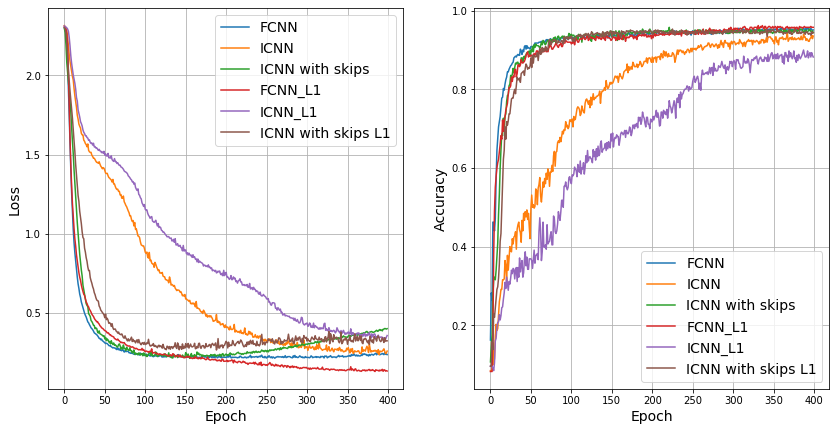

In [199]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axs[0].grid()
axs[0].plot(fcn_val_losses, label="FCNN")
axs[0].plot(icnn_val_losses, label="ICNN")
axs[0].plot(icnnskips_val_losses, label="ICNN with skips")
axs[0].plot(fcnl1_val_losses, label="FCNN_L1")
axs[0].plot(icnnl1_val_losses, label="ICNN_L1")
axs[0].plot(icnnskipsl1_val_losse, label="ICNN with skips L1")
axs[0].set_xlabel("Epoch", fontsize=14)
axs[0].set_ylabel("Loss", fontsize=14)
axs[0].legend(fontsize=14)

axs[1].grid()
axs[1].plot(fcn_val_accs, label="FCNN")
axs[1].plot(icnn_val_accs, label="ICNN")
axs[1].plot(icnnskips_val_accs, label="ICNN with skips")
axs[1].plot(fcnl1_val_accs, label="FCNN_L1")
axs[1].plot(icnnl1_val_accs, label="ICNN_L1")
axs[1].plot(icnnskipsl1_val_accs, label="ICNN with skips L1")
axs[1].set_xlabel("Epoch", fontsize=14)
axs[1].set_ylabel("Accuracy", fontsize=14)
axs[1].legend(fontsize=14)
plt.show()